# COGS 118A - Final Project

# Chess Winner Prediction and Data Analysis

## Group members

- Kalam Park
- Kira Fleischer
- Cray Minor

# Abstract 


The goal of the reserach is to take advatnage of Lichess's online recorded Chess matches to determine the factors that most strongly influences winning and to build a model that is able to predict the winner within just the first couple moves. The data used in this project represents various quantitative and qualitative measures of the competitors (~20,000 matches), in which used Logistic Regression as a baseline model using a selection of k = 15 best features. In addition, we performed model selection from Random Forests, Support Vector Machines, and Decision Tree algorithms using precision, recall, F1 score, and found Random Forest to perform best across all scores at 65% correct winner prediction. This research aims to contribute to the understanding of complex competition, as well as assist in developing game strategies that closely links to success.

# Background

Chess is one of the world's most popular strategy games to date, and its ever-growing popularity has been heavily expedited due to the growing number of online platforms (Chess.com, Lichess) and users. With numerous events, streams, tutors, and creators online, chess can now be played and learned virtually anytime, anywhere. With the insurmountable amount of variations, openings, and data that comes with chess, the average player likely just scracthes the surface in understanding the deep complexity the game consists of. The emergence of AI and machine learning have offered a solution to this common dilemma, by providing a way to compute the mass amounts of available data and train the computer to do the thinking for them. That being said, AI and chess bots are amongst the most well known examples, popular for its near perfect chess performance, as well as a way of cheating.<a name="lorenz"></a>[<sup>[1]</sup>](#lorenznote) There has also been a lot of research on chess analysis and playing, such as Stockfish project, an opensource chess analysis algorithm which can provide players with an after game review with one of the most powerful chessbots.<a name="lorenz"></a>[<sup>[2]</sup>](#lorenznote) Evidently such knowledge can be highly beneficial in strategizing moves, openings, and sequences.

Similarly, our proposed work aims to provide helpful information by analyzing 20,000 Lichess matches and highlighting the variables that most heavily influences a user to win the match. Upon gathering these factors, we plan to restructure and split the dataset in order to train a model into predicting a winner based on some user inputs. This in hopes will help users strategize between openings, first moves, and help determine if white pieces really have an inherent advantage in novice to professional level matches. <a name="lorenz"></a>[<sup>[3]</sup>](#lorenznote)


# Problem Statement

Each side starting with 16 pieces, 6 different roles, and 64 squares there are nearly 10^120 different chess game variations, also known as Shannon's Number, which is more than there are atoms in the observable universe. <a name="lorenz"></a>[<sup>[4]</sup>](#lorenznote) We will be looking at the different features contained within our data to see the highest correlated with a win for white(1), a win for black(0), or a draw (2). Logistic Regression will serve as our baseline classifier because of its simplicity and replicability. We will compare its performance to more complex algorithms such as Random Forests and Support Vector Machinees quantified using confusion matricies and a ROC curve. After evaluation we select the model that performs best on the test and validation sets and its ability to generalize, to provide a comprehensive analysis of these games and potential winning strategies. 


# Data


### Chess Game Dataset - Lichess (https://www.kaggle.com/datasets/datasnaek/chess)
- A collection of 20,058 recorded chess matches between two Lichess users 
- Contains 16 variables 
    - Game ID; 
    - Rated (T/F);
    - Start Time;
    - End Time;
    - Number of Turns;
    - Game Status;
    - Winner;
    - Time Increment;
    - White Player ID;
    - White Player Rating;
    - Black Player ID;
    - Black Player Rating;
    - All Moves in Standard Chess Notation;
    - Opening Eco (Standardised Code for any given opening, list here);
    - Opening Name;
    - Opening Ply (Number of moves in the opening phase)


- Evidently some varibales will be more impactful than others, some critical ones are as listed:
    - White/Black rating (ranking)
    - Opening move 
    - Piece colors

A lot of the categorzing is done for us since each opening move has a respective eco code. There are some varibales such as Game status and Winner that can be categorized numerically. We also plan to just completely remove some variables we believe should have no impact or influence on predicting who would win a game (ex: Game status, All Moves in Standard Chess Notation, Game ID, player IDs, etc.)


### Data Cleaning 

**Import relevant packages**

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split, LearningCurveDisplay, learning_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

**Bring data csv into pandas dataframe & set match ID as index**

In [2]:
df = pd.read_csv('data/games.csv').set_index('id')

#convert unix time so it's readable 
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')
df['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms')
df.head(3)

,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
id,,,,,,,,,,,,,,,
TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


**Converted time but its the same so we remove these columns, and player ID for privacy reasons nor does it relate to our project**

In [3]:
df = df.drop(['created_at', 'last_move_at'], axis=1)
df = df.drop(['white_id', 'black_id'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20058 entries, TZJHLljE to N8G2JHGG
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rated           20058 non-null  bool  
 1   turns           20058 non-null  int64 
 2   victory_status  20058 non-null  object
 3   winner          20058 non-null  object
 4   increment_code  20058 non-null  object
 5   white_rating    20058 non-null  int64 
 6   black_rating    20058 non-null  int64 
 7   moves           20058 non-null  object
 8   opening_eco     20058 non-null  object
 9   opening_name    20058 non-null  object
 10  opening_ply     20058 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 1.7+ MB


**Examining popular openings before dropping**

In [5]:
print(f"First 11 openings:")
df['opening_name'].value_counts()[:11]

First 11 openings:


Van't Kruijs Opening                             368
Sicilian Defense                                 358
Sicilian Defense: Bowdler Attack                 296
Scotch Game                                      271
French Defense: Knight Variation                 271
Scandinavian Defense: Mieses-Kotroc Variation    259
Queen's Pawn Game: Mason Attack                  232
Queen's Pawn Game: Chigorin Variation            229
Scandinavian Defense                             223
Horwitz Defense                                  209
Caro-Kann Defense                                199
Name: opening_name, dtype: int64

In [6]:
print("The best openings with white: ")
Gr_white = df[df['winner']=='white']
Gr_white[['opening_name', 'winner']].value_counts().sort_values(ascending=False)[:10]

The best openings with white: 


opening_name                                   winner
Scandinavian Defense: Mieses-Kotroc Variation  white     164
Sicilian Defense                               white     149
Scotch Game                                    white     145
French Defense: Knight Variation               white     135
Philidor Defense #3                            white     127
Van't Kruijs Opening                           white     126
Sicilian Defense: Bowdler Attack               white     119
Queen's Pawn Game: Mason Attack                white     116
Queen's Pawn Game: Chigorin Variation          white     112
Horwitz Defense                                white     110
dtype: int64

In [7]:
print("The best openings with Black: ")
Gr_black = df[df['winner']=='black']
Gr_black[['opening_name', 'winner']].value_counts().sort_values(ascending=False)[:10]

The best openings with Black: 


opening_name                           winner
Van't Kruijs Opening                   black     226
Sicilian Defense                       black     194
Sicilian Defense: Bowdler Attack       black     164
Scandinavian Defense                   black     123
French Defense: Knight Variation       black     121
Scotch Game                            black     115
Queen's Pawn Game: Chigorin Variation  black     109
Queen's Pawn Game: Mason Attack        black     103
Indian Game                            black     100
Philidor Defense #2                    black      96
dtype: int64

**Encode the opening names by the amount of wins, 0.5 for a draw, and subtract from how many losses it has**

In [8]:
opening_wins = df.groupby('opening_name')['winner'].apply(lambda x: (x == 'black').sum())
opening_losses = df.groupby('opening_name')['winner'].apply(lambda x: (x == 'white').sum())
opening_draws = df.groupby('opening_name')['winner'].apply(lambda x: (x == 'draw').sum())

opening_score = opening_wins + 0.5*opening_draws - opening_losses

opening_score_dict = opening_score.to_dict()

df['opening_encoded'] = df['opening_name'].apply(lambda x: opening_score_dict[x])

**The opening name should also be removed, opening name is repetitive**

In [9]:
df = df.drop(['opening_name'], axis=1)

**Numerically encode the rated, winner, and victory_status column strings**

In [10]:
df['rated'] = df['rated'].astype(int)
df['winner'] = df['winner'].replace({'white': 0, 'black': 1, 'draw': 2}).astype(int)
df['victory_status'] = df['victory_status'].replace({'mate': 0, 'resign': 1, 'draw': 2, 'outoftime': 3}).astype(int)

In [11]:
df.shape

(20058, 11)

**Instead of looking through a mass number of different moves and ecos, let's just consider the players' first moves for a cleaner analysis**

Here's a link that go over the different eco codes and their groups/names: https://www.365chess.com/eco.php

In [12]:
def getFirstTwoMoves(moves):
    splitted = moves.split(maxsplit=2)
    if len(splitted) < 2:
        return np.nan, np.nan
    return splitted[0], splitted[1]

In [13]:
first_two_moves = np.vectorize(getFirstTwoMoves)(df['moves'])
df['white_first_move'], df['black_first_move'] = first_two_moves[0], first_two_moves[1]
df = df.drop(['opening_eco', 'moves'], axis=1)

**Check for missing values, NaNs, and nulls**

In [14]:
df.isna().any()

rated               False
turns               False
victory_status      False
winner              False
increment_code      False
white_rating        False
black_rating        False
opening_ply         False
opening_encoded     False
white_first_move    False
black_first_move    False
dtype: bool

**The time increment is hard to read and has way too many variations as well. So let's break them down and group them together solely based on the minutes allowed in the game and ignoring the extra seconds**

In [15]:
def deletePlusSuffix(inc):
    splitted = inc.split('+')
    return int(splitted[0])

#group the following categories into their respective time groups
def CategorizeInc(inc):
    if inc < 3:
        return 'bullet'    
    elif inc < 9:
        return 'blitz'
    elif inc < 16:
        return 'rapid'
    else:
        return 'classical'

In [16]:
#apply the functions to the increment_code column
df['increment_code'] = np.vectorize(deletePlusSuffix)(df['increment_code'])
df['increment_code'] = np.vectorize(CategorizeInc)(df['increment_code'])

**It can be also beneficial to add a column that holds the disparity between the two players' ratings. The logic is higher disparity = greater probability to win**

In [17]:
df['rating_difference'] = df['white_rating'] - df['black_rating']

In [18]:
# calculate the IQR of the DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# identify outliers by checking which values fall outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

# remove outliers from the DataFrame
df = df[~outliers.any(axis=1)]

/var/folders/8n/mnfgwnzn6g392_syppl5nr3m0000gn/T/ipykernel_60932/765194095.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
/var/folders/8n/mnfgwnzn6g392_syppl5nr3m0000gn/T/ipykernel_60932/765194095.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
/var/folders/8n/mnfgwnzn6g392_syppl5nr3m0000gn/T/ipykernel_60932/765194095.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3

**Check for duplicate games and delete them**

In [19]:
print(f"\nNumber of rows before = {str(df.shape[0])[:2]},{str(df.shape[0])[2:]}")
print('Number of duplicated rows in data: ',df.duplicated().sum())

df = df.drop_duplicates()
print(f"\nNumber of rows after duplicate drop = {str(df.shape[0])[:2]},{str(df.shape[0])[2:]}")
print('Number of duplicated rows in data: ',df.duplicated().sum())


Number of rows before = 11,175
Number of duplicated rows in data:  481

Number of rows after duplicate drop = 10,694
Number of duplicated rows in data:  0


**Here's a preview of the final dataframe**

In [20]:
df

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_ply,opening_encoded,white_first_move,black_first_move,rating_difference
id,,,,,,,,,,,,
l1NXvwaE,1,16,1,1,blitz,1322,1261,4,-1.0,d4,Nc6,61
mIICvQHh,1,61,0,0,blitz,1496,1500,3,18.0,e4,e5,-4
kWKvrqYL,1,61,0,0,classical,1439,1454,3,-15.5,d4,d5,-15
qwU9rasv,1,33,1,0,rapid,1520,1423,10,-2.0,d4,d5,97
dwF3DJHO,1,66,1,1,rapid,1439,1392,6,13.5,e4,e5,47
...,...,...,...,...,...,...,...,...,...,...,...,...
uMzb0TPC,1,58,0,1,rapid,1237,1231,3,-6.5,e4,e6,6
EopEqqAa,1,37,1,0,rapid,1219,1250,4,-0.5,c4,e6,-31
yrAas0Kj,1,35,0,0,rapid,1219,1286,3,-6.5,d4,d5,-67


# Proposed Solution

In order to predict the winner of the chess game, we will compare three different classification models and select the best one based on their respective performances, as measured by the evaluation metrics accuracy and f1 score. The three models we will use are:

1. Logistic Regression

Logistic regression is a method that aims to fit a linear decision boundary that separates classes based on their input features. Since there are three outcomes in our dataset, white win (1), black win (0), and draw (2), we will use use a one vs rest classifier in our logistic regression model to classify the three outcomes. In order to implement this model, we will split our dataset into training, validation, and test sets, where we will first train the model, tune the hyperparameters using the validation set, evaluate it based on accuracy and f1 score, and finally predict classifications using the test set. We will use gradient descent to find the best hyperparameters that minimize the loss function.

2. Random Forests

Random forests is a method that combines multiple decision trees that are each trained on a random subset of the training data and a random subset of the input features. We are using random forests because this method has many advantages over simple decision trees. For instance, random forests reduce overfitting by averaging the predictions of many decision trees. More importantly, however, random forests provide a measure of the importance of each feature by evaluating how much the performance of the model changes when different features are removed. This will help us determine which feature (player ratings, opening moves, piece color, etc.) are most important in predicting a winner. We will follow a similar method as with Logistic Regression to evaluate our Random Forests model. That is, we will split the data into training and test sets, train the model on the training set, tune the hyperparameters on the training set using k-fold cross-validation, evaluate the model based on accuaracy and f1 score, and finally predict classifications using the test set.

3. SVM

SVM is a method that aims to find a hyperplane that separates classes while creating the largest margin between the classes, which is determined by support vectors within the classes. This is achieved by minimizing a loss function that accounts for both misclassification errors and points that are within the margin surrounding the decision boundary hyperplane. We will most likely use linear SVM since this handles large datasets well, and we do not anticipate any curvature to or nonlinear patters in the data. As with the Logistic Regression and Random Forests models, we will begin by splitting our data set into training and test sets. Then we will train the model on the traning set using a one vs one classifier. Next we will tune the hyperparameters on the training set using k-fold cross-validation and evaluate the model based on accuracy and f1 score, and finally we will predict classifications using the test set.

# Evaluation Metrics

We will evaluate our model performances using the metrics accuracy and f1 score. 

Accuracy will be calculated by dividing the the number of correct predictions (e.g. white predicted to win and white actually wins) by the number of total predictions (the total training set size):

    accuracy = (number of correct predictions) / (number of total predictions)

This will give a pretty good estimate of which model is best at accurately predicting who will win since this is the most direct computation. 

Additionally, we will calculate the f1 score to compare our models. Since there are 3 outcomes in our classification problem, we must use a weighted average f1 score. That means precision, recall, and f1 score will be calculated 3 times each. Each class (white win, black win, and draw) will serve as the positive class for one round of calculations, with the remaining two classes serving as the negative class. For example, for one calculation of precision, recall and f1 score, white win will be the positive class, and black win or draw will be the negative class. Precision, recall, and f1 score will be calculated by the following formulae:

    TP = number of instances correctly classified as positive class (e.g. white win predicted as white win)
    FP = number of instances incorrectly classified as positive class (e.g. black win or draw predicted as white win)
    FN = number of instances incorrectly classified as negative class (e.g. white win predicted as black win or draw)
    TN = number of instances correctly classified as negative class (e.g. black win or draw predicted as black win or draw)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 score = (2 * precision * recall) / (precision + recall)

To calculate the weighted average f1 score, we will use the following formulae:

    N_white_win = number of instances in dataset of white win
    N_black_win = number of instances in dataset of black win
    N_draw = number of instances in dataset of draw
    N_total = number of total instances in dataset
    f1 weighted average = ((F1 score white win * N_white_win) + (F1 score black win * N_black_win) + (F1 score draw * N_draw)) / N_total

We wanted to use the weighted average f1 score to account for the imbalanced class sizes we have, since there are significantly fewer instances of draws than of white wins or black wins. The weighted average f1 score gives more weight to classes that have more instances, so this works well in our situation.

# Results




# **Subsection 1** - EDA

In [21]:
df.head() #for reference 

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_ply,opening_encoded,white_first_move,black_first_move,rating_difference
id,,,,,,,,,,,,
l1NXvwaE,1,16,1,1,blitz,1322,1261,4,-1.0,d4,Nc6,61
mIICvQHh,1,61,0,0,blitz,1496,1500,3,18.0,e4,e5,-4
kWKvrqYL,1,61,0,0,classical,1439,1454,3,-15.5,d4,d5,-15
qwU9rasv,1,33,1,0,rapid,1520,1423,10,-2.0,d4,d5,97
dwF3DJHO,1,66,1,1,rapid,1439,1392,6,13.5,e4,e5,47


In [22]:
labels = {0: 'white', 1: 'black', 2: 'draw'}

**White tends to win more games on average, seems they do have some inherent advantage from moving first**

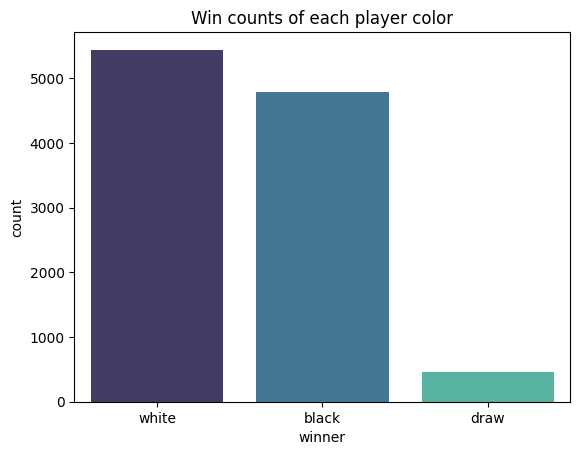

In [23]:
ax = sns.countplot(data=df, x='winner', palette='mako')
ax.set(title='Win counts of each player color')
ax.set_xticklabels(['white', 'black', 'draw'])
plt.show()

**Outcome distributions for each game type is similar but we can see rapid is the most popular game type**

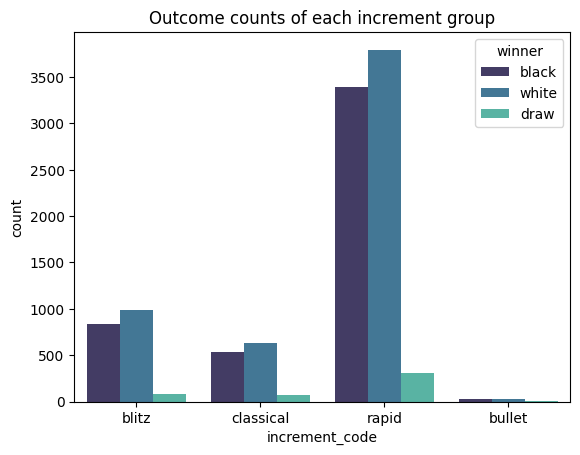

In [24]:
ax = sns.countplot(data=df, x='increment_code', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Outcome counts of each increment group')
plt.show()

**Examining Popular opening moves for each color pieces**

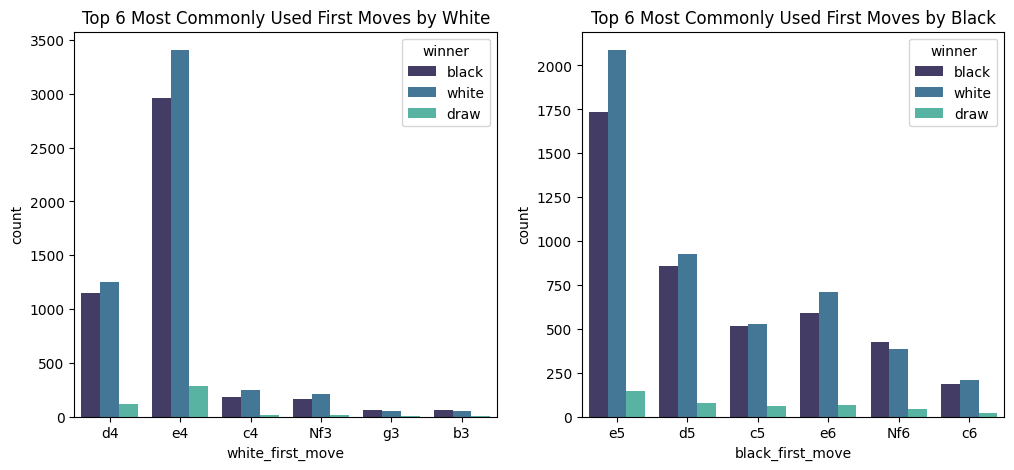

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Plot white first moves
fm = dict(df.white_first_move.value_counts(ascending=False)[0:6])
first_moves_w = list(fm.keys())
fm_df = df[df.white_first_move.isin(first_moves_w)]
sns.countplot(data=fm_df, x='white_first_move', palette='mako', hue=df['winner'].map(labels), ax=axes[0])
axes[0].set_title('Top 6 Most Commonly Used First Moves by White')

# Plot black first moves
fm1 = dict(df.black_first_move.value_counts(ascending=False)[0:6])
first_moves_b = list(fm1.keys())
fm1_df = df[df.black_first_move.isin(first_moves_b)]
sns.countplot(data=fm1_df, x='black_first_move', palette='mako', hue=df['winner'].map(labels), ax=axes[1])
axes[1].set_title('Top 6 Most Commonly Used First Moves by Black')

# Display the plot
plt.show()

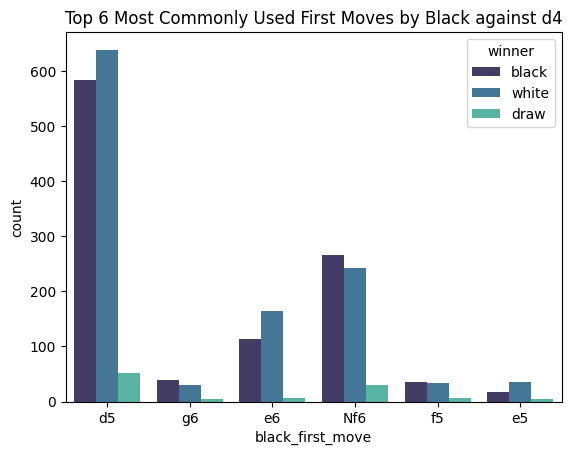

In [26]:
fm_df = df.loc[df.white_first_move == 'd4']
fm = dict(fm_df.black_first_move.value_counts(ascending=False)[0:6])
b_d4 = list(fm.keys())
fm_df = fm_df[fm_df.black_first_move.isin(b_d4)]

ax = sns.countplot(data=fm_df, x='black_first_move', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Top 6 Most Commonly Used First Moves by Black against d4')
plt.show()

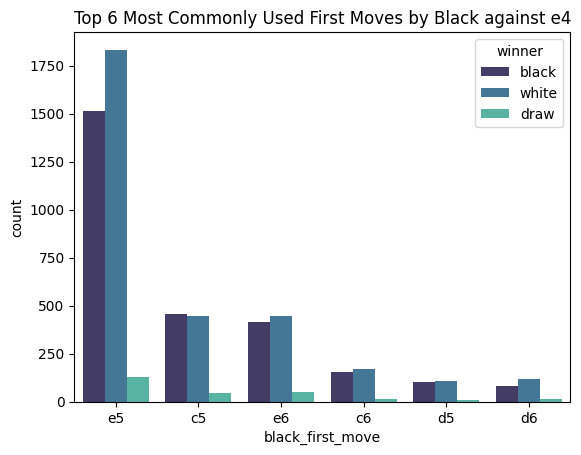

In [27]:
fm_df1 = df.loc[df.white_first_move == 'e4']
fm1 = dict(fm_df1.black_first_move.value_counts(ascending=False)[0:6])
b_e4 = list(fm1.keys())
fm_df1 = fm_df1[fm_df1.black_first_move.isin(b_e4)]

ax = sns.countplot(data=fm_df1, x='black_first_move', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Top 6 Most Commonly Used First Moves by Black against e4')
plt.show()

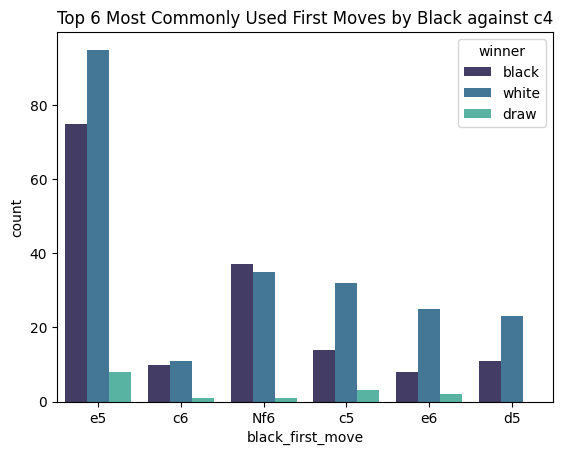

In [28]:
fm_df2 = df.loc[df.white_first_move == 'c4']
fm2 = dict(fm_df2.black_first_move.value_counts(ascending=False)[0:6])
b_c4 = list(fm2.keys())
fm_df2 = fm_df2[fm_df2.black_first_move.isin(b_c4)]

ax = sns.countplot(data=fm_df2, x='black_first_move', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Top 6 Most Commonly Used First Moves by Black against c4')
plt.show()

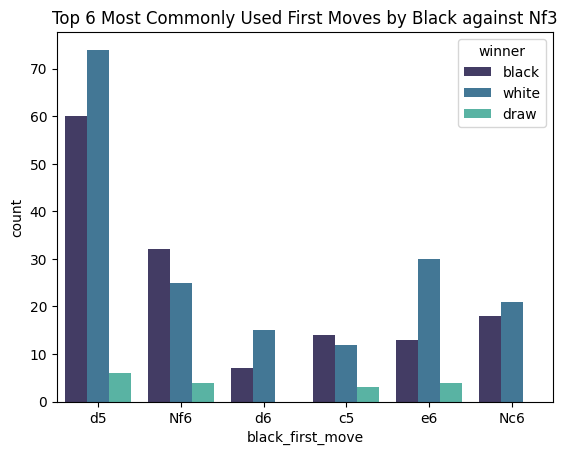

In [29]:
fm_df3 = df.loc[df.white_first_move == 'Nf3']
fm3 = dict(fm_df3.black_first_move.value_counts(ascending=False)[0:6])
b_Nf3 = list(fm3.keys())
fm_df3 = fm_df3[fm_df3.black_first_move.isin(b_Nf3)]

ax = sns.countplot(data=fm_df3, x='black_first_move', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Top 6 Most Commonly Used First Moves by Black against Nf3')
plt.show()

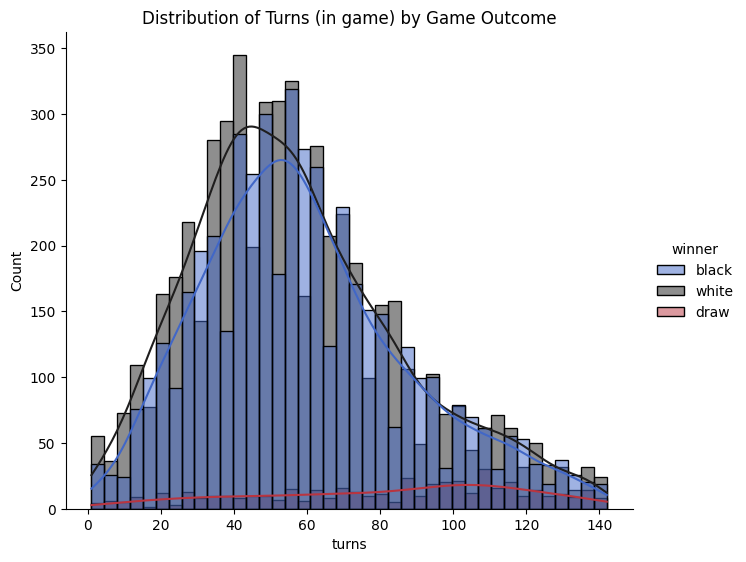

In [30]:
ax = sns.displot(df, x='turns', hue=df['winner'].map(labels), palette='icefire', 
                 kde=True, height=5.5, aspect=1.2)
ax.set(title='Distribution of Turns (in game) by Game Outcome')
plt.show()

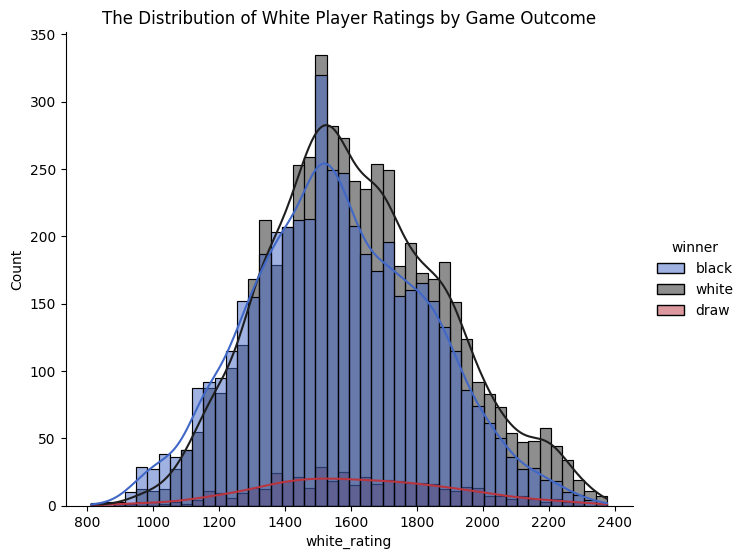

In [31]:
ax = sns.displot(df, x='white_rating', hue=df['winner'].map(labels), palette='icefire', 
                 kde=True, height=5.5, aspect=1.2)
plt.title('The Distribution of White Player Ratings by Game Outcome')
plt.show()

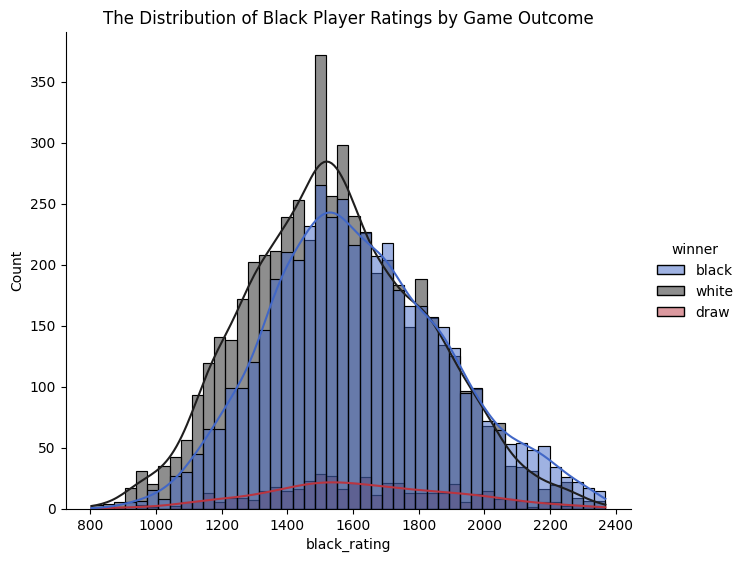

In [32]:
ax = sns.displot(df, x='black_rating', hue=df['winner'].map(labels), palette='icefire', 
                 kde=True, height=5.5, aspect=1.2)
plt.title('The Distribution of Black Player Ratings by Game Outcome')
plt.show()

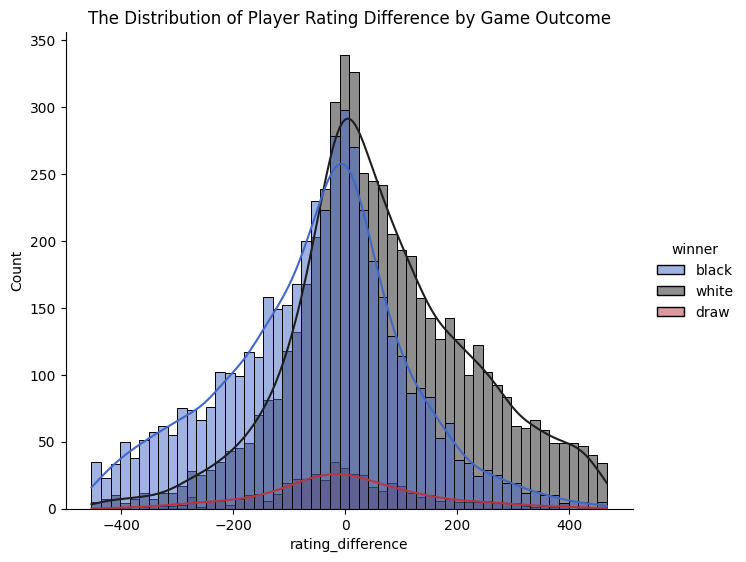

In [33]:
ax = sns.displot(df, x='rating_difference', hue=df['winner'].map(labels), palette='icefire', 
                 kde=True, height=5.5, aspect=1.2)
plt.title('The Distribution of Player Rating Difference by Game Outcome')
plt.show()

#### SInce EDA is finished, we get rid of the draws to improve our accuracies and rated column to improve accuracy

In [34]:
df = df[df['winner'] != 2]
df = df.drop(['rated'], axis=1)

# **Subsection 2** - Feature selection & transformation

In [35]:
df.head(2)

,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_ply,opening_encoded,white_first_move,black_first_move,rating_difference
id,,,,,,,,,,,
l1NXvwaE,16,1,1,blitz,1322,1261,4,-1.0,d4,Nc6,61
mIICvQHh,61,0,0,blitz,1496,1500,3,18.0,e4,e5,-4


**One hot encode categorical columns left over, and apply a standard scalar, then select the best features**

In [36]:
X = df.drop('winner', axis=1)
y = df['winner']

# Transform categorical variables using one-hot encoding
cat_cols = ['victory_status', 'increment_code', 'white_first_move', 'black_first_move']
num_cols = ['turns', 'white_rating', 'black_rating', 'opening_ply', 'opening_encoded', 'rating_difference']
transformer = ColumnTransformer([('one_hot', OneHotEncoder(), cat_cols)], remainder='passthrough')
X_transformed = transformer.fit_transform(X)

# Scale numerical variables
scaler = StandardScaler(with_mean = False)
X_transformed[:, -5:] = scaler.fit_transform(X_transformed[:, -5:])

# Apply TruncatedSVD
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_transformed, y)

In [37]:
# Get the boolean array of selected features
selected_features = selector.get_support()

In [38]:
one_hot_names = transformer.named_transformers_['one_hot'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([one_hot_names, num_cols])
selected_feature_names = all_feature_names[selected_features]
print(selected_feature_names)

['victory_status_0' 'victory_status_1' 'white_first_move_a3'
 'white_first_move_a4' 'white_first_move_c4' 'white_first_move_d3'
 'black_first_move_Na6' 'black_first_move_Nf6' 'black_first_move_d6'
 'black_first_move_e5' 'turns' 'white_rating' 'black_rating'
 'opening_encoded' 'rating_difference']


# **Subsection 3** - Logistic Regression (Model Selection)

**Create baseline Logistic Regression model and perform grid search cross-validation to find the best combination of hyperparameters, after elimination of outliers baseline performance increased 2-5% in later runs**

In [ ]:
# Define hyperparameters and cross-validation settings
hyperparameters = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'class_weight': [None, 'balanced']
}

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a logistic regression model
clf = LogisticRegression(random_state=42, max_iter=1000)

# Perform a grid search over the hyperparameters
grid_search = GridSearchCV(clf, hyperparameters, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

In [40]:
# Define best hyperparameters
penalty_best = grid_search.best_params_['penalty']
C_best = grid_search.best_params_['C']
weight_best = grid_search.best_params_['class_weight']
solver_best = grid_search.best_params_['solver']

# Fit a Logistic Regression model with best parameters
clf_best = LogisticRegression(penalty=penalty_best, C=C_best, class_weight=weight_best, random_state=42, solver=solver_best, max_iter=1000)
clf_best.fit(X_train, y_train)

# Predict the test set labels
y_pred = clf_best.predict(X_test)
scores = cross_val_score(clf, X_transformed, y, cv=10)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)

f1_scores = cross_val_score(clf, X_transformed, y, cv=10, scoring='f1_macro')
recall_scores = cross_val_score(clf, X_transformed, y, cv=10, scoring='recall_macro')
precision_scores = cross_val_score(clf, X_transformed, y, cv=10, scoring='precision_macro')

print("Best hyperparameters:", grid_search.best_params_)
print("Best mean accuracy:", grid_search.best_score_)
print('Accuracy:', accuracy)
print('Mean accuracy:', np.mean(scores))
print('Mean f1 score:', np.mean(f1_scores))
print('Mean recall:', np.mean(recall_scores))
print('Mean precision:', np.mean(precision_scores))

Best hyperparameters: {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best mean accuracy: 0.6519685567944579
Accuracy: 0.6497313141182218
Mean accuracy: 0.6448772948741447
Mean f1 score: 0.6410214593921572
Mean recall: 0.6410091947324601
Mean precision: 0.643525107925185


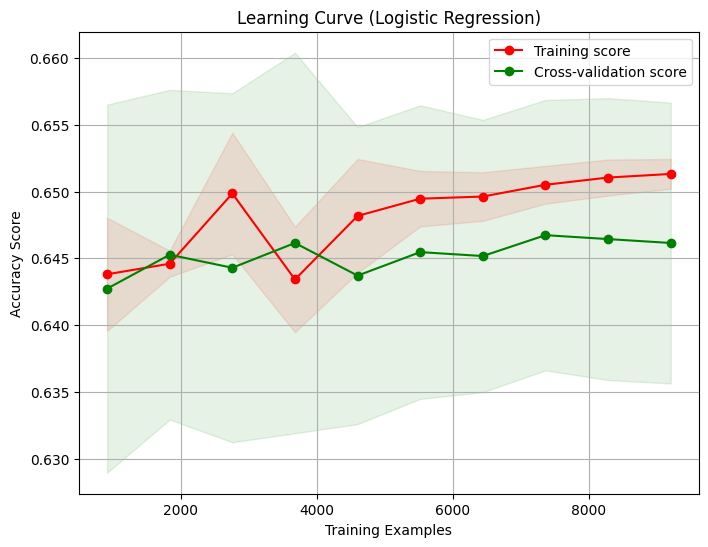

In [41]:
clf = clf_best
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(clf, X_transformed, y, train_sizes=train_sizes, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

# **Subsection 4** - Random Forest (Model Selection)

**Begin model selection with Random Forest**

In [42]:
# Define hyperparameters and cross-validation settings
hyperparameters = {
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 4, 6]
}

# Create a logistic regression model
rf = RandomForestClassifier(random_state=42)

# Perform a grid search over the hyperparameters
grid_search_rf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [10, 100]})

In [43]:
# Define best hyperparameters
n_estimators_best = grid_search_rf.best_params_['n_estimators']
criterion_best = grid_search_rf.best_params_['criterion']
min_samples_split_best = grid_search_rf.best_params_['min_samples_split']

# Fit a Random Forests Classifier with best parameters
rf_best = RandomForestClassifier(n_estimators=n_estimators_best, criterion=criterion_best, min_samples_split=min_samples_split_best, random_state=42)
rf_best.fit(X_train, y_train)

# Predict the test set labels
y_pred = rf_best.predict(X_test)

# Compute the scores
accuracy = accuracy_score(y_test, y_pred)
f1_scores_rf = cross_val_score(rf_best, X_transformed, y, cv=10, scoring='f1_macro')
recall_scores_rf = cross_val_score(rf_best, X_transformed, y, cv=10, scoring='recall_macro')
precision_scores_rf = cross_val_score(rf_best, X_transformed, y, cv=10, scoring='precision_macro')

# Print statements
print("Best hyperparameters:", grid_search_rf.best_params_)
print("Best mean accuracy:", grid_search_rf.best_score_)
print('Mean f1 score:', np.mean(f1_scores_rf))
print('Mean recall:', np.mean(recall_scores_rf))
print('Mean precision:', np.mean(precision_scores_rf))

Best hyperparameters: {'criterion': 'gini', 'min_samples_split': 6, 'n_estimators': 100}
Best mean accuracy: 0.6611298699264491
Accuracy: 0.6619443087445042
Mean f1 score: 0.6517804373565493
Mean recall: 0.6516136735046818
Mean precision: 0.6536019961188279


**Random Forest Learning Curve - overfit on train data, but highest accuracy and f1 score.**

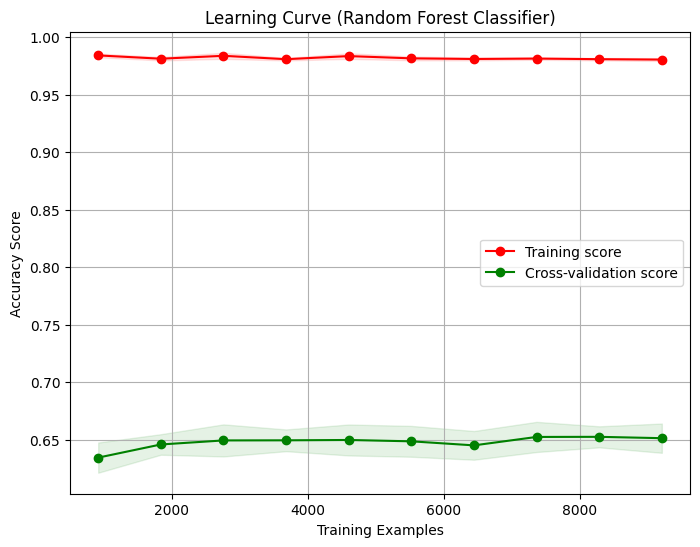

In [44]:
clf_rf = rf_best

train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(clf_rf, X_transformed, y, train_sizes=train_sizes, cv=10, scoring='accuracy')

train_scores_mean_rf = np.mean(train_scores_rf, axis=1)
train_scores_std_rf = np.std(train_scores_rf, axis=1)
test_scores_mean_rf = np.mean(test_scores_rf, axis=1)
test_scores_std_rf = np.std(test_scores_rf, axis=1)

plt.figure(figsize=(8,6))
plt.title("Learning Curve (Random Forest Classifier)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.grid()
plt.fill_between(train_sizes_rf, train_scores_mean_rf - train_scores_std_rf,
                 train_scores_mean_rf + train_scores_std_rf, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_rf, test_scores_mean_rf - test_scores_std_rf,
                 test_scores_mean_rf + test_scores_std_rf, alpha=0.1,
                 color="g")
plt.plot(train_sizes_rf, train_scores_mean_rf, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_rf, test_scores_mean_rf, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

# **Subsection 5** - SVM (Model Selection)

**Support Vector Machine model selection because Random Forest performed similar to Logistic Regression, we want to get better predictions**

In [45]:
# Create a SVM model
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Predict the test set labels
y_pred = svm.predict(X_test)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)
f1_scores_svm = cross_val_score(svm, X_transformed, y, cv=10, scoring='f1_macro')
recall_scores_svm = cross_val_score(svm, X_transformed, y, cv=10, scoring='recall_macro')
precision_scores_svm = cross_val_score(svm, X_transformed, y, cv=10, scoring='precision_macro')

#Print Statements
print('Accuracy:', accuracy)
print('Mean f1 score:', np.mean(f1_scores_svm))
print('Mean recall:', np.mean(recall_scores_svm))
print('Mean precision:', np.mean(precision_scores_svm))

Accuracy: 0.6365412799218368
Mean f1 score: 0.6284457513669129
Mean recall: 0.6320657126428171
Mean precision: 0.6455048728421645


**Support Vector Machine Learning Curve - it performed worse than Random Forest & Logistic Regression so we will test another model**

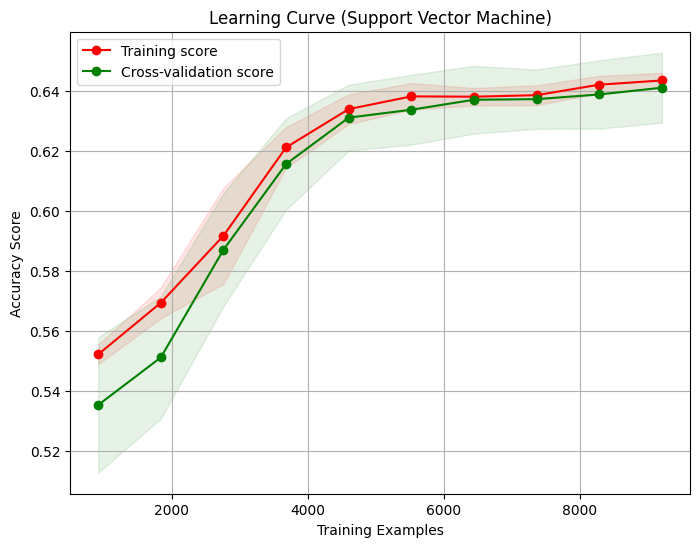

In [46]:
clf_svm = svm

train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(clf_svm, X_transformed, y, train_sizes=train_sizes, cv=10, scoring='accuracy')

train_scores_mean_svm = np.mean(train_scores_svm, axis=1)
train_scores_std_svm = np.std(train_scores_svm, axis=1)
test_scores_mean_svm = np.mean(test_scores_svm, axis=1)
test_scores_std_svm = np.std(test_scores_svm, axis=1)

plt.figure(figsize=(8,6))
plt.title("Learning Curve (Support Vector Machine)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.grid()
plt.fill_between(train_sizes_svm, train_scores_mean_svm - train_scores_std_svm,
                 train_scores_mean_svm + train_scores_std_svm, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_svm, test_scores_mean_svm - test_scores_std_svm,
                 test_scores_mean_svm + test_scores_std_svm, alpha=0.1,
                 color="g")
plt.plot(train_sizes_svm, train_scores_mean_svm, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_svm, test_scores_mean_svm, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

# **Subsection 6** - Decision Tree (Model Selection)

**We did not get get performance we expected, we will continue model selection with Decision Trees doing a grid search to find the best fit and see if there is any improvement**

In [47]:
# Define the hyperparameters to search over
param = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create the GridSearchCV object
grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param,
    scoring='accuracy',
    cv=5, # Specify the number of folds for cross-validation
    n_jobs=-1, # Use all available CPU cores
)

# Fit the GridSearchCV object on the training set
grid_search_dt.fit(X_train, y_train)

# Use the best hyperparameters to fit a Decision Tree model
DT_best = DecisionTreeClassifier(**grid_search_dt.best_params_, random_state=42)
DT_best.fit(X_train, y_train)

# Predict the test set labels
y_pred = DT_best.predict(X_test)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)
f1_scores_dt = cross_val_score(DT_best, X_transformed, y, cv=10, scoring='f1_macro')
recall_scores_dt = cross_val_score(DT_best, X_transformed, y, cv=10, scoring='recall_macro')
precision_scores_dt = cross_val_score(DT_best, X_transformed, y, cv=10, scoring='precision_macro')

# Print statements
print("Best hyperparameters:", grid_search_dt.best_params_)
print("Best mean accuracy:", grid_search_dt.best_score_)
print('Accuracy:', accuracy)
print('Mean f1 score:', np.mean(f1_scores_dt))
print('Mean recall:', np.mean(recall_scores_dt))
print('Mean precision:', np.mean(precision_scores_dt))

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best mean accuracy: 0.6606410219116389
Accuracy: 0.6521739130434783
Mean f1 score: 0.6487638757539334
Mean recall: 0.6489556865270671
Mean precision: 0.6523634153394617


**Decision Tree Learning Curve - performed similar to Random forest, accuracy = 66% and quickest to train**

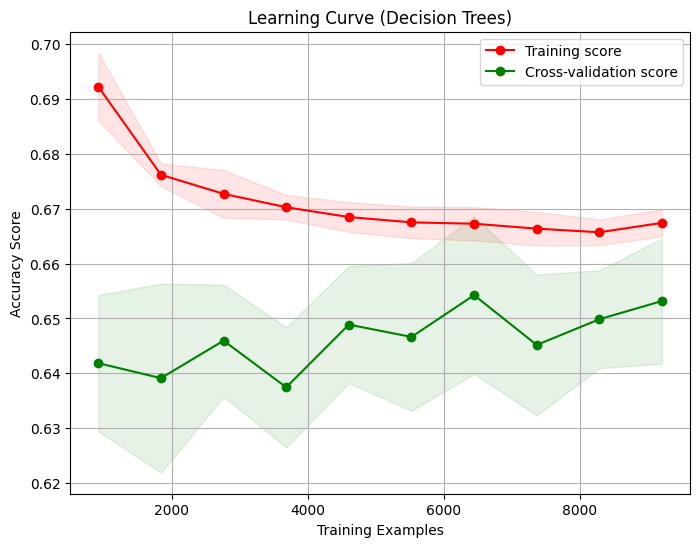

In [48]:
clf_dt = DT_best

train_sizes_dt, train_scores_dt, test_scores_dt = learning_curve(clf_dt, X_transformed, y, train_sizes=train_sizes, cv=10, scoring='accuracy')

train_scores_mean_dt = np.mean(train_scores_dt, axis=1)
train_scores_std_dt = np.std(train_scores_dt, axis=1)
test_scores_mean_dt = np.mean(test_scores_dt, axis=1)
test_scores_std_dt = np.std(test_scores_dt, axis=1)

plt.figure(figsize=(8,6))
plt.title("Learning Curve (Decision Trees)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.grid()
plt.fill_between(train_sizes_dt, train_scores_mean_dt - train_scores_std_dt,
                 train_scores_mean_dt + train_scores_std_dt, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_dt, test_scores_mean_dt - test_scores_std_dt,
                 test_scores_mean_dt + test_scores_std_dt, alpha=0.1,
                 color="g")
plt.plot(train_sizes_dt, train_scores_mean_dt, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_dt, test_scores_mean_dt, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()


# Discussion

### Interpreting the result


To determine the best model for predicting chess winners, we created 4 different models and performed cross-validation on each so that each model performed as best it could. Based on the accuracies and weighted f1 scores of the 4 different models, the random forests classifier performed the best with the highest accuracy of 66.11% and highest weighted f1 score of 65.17%. However, all of the models were very similar with metrics around 64%, with the lowest accuracy and f1 score being 63.65% and 62.84%, respectively, from the decision trees model. Since all of the scores were so similar, the random forests or decision trees are the best models because they trained the fastest. 

One of the biggest challenges we faced was how to increase the accuracy of our models. Since none of the models could break 65% accuracy, none are particularly good at predicting chess winners; it is estimated that white wins up to 56% of the time <a name="lorenz"></a>[<sup>[3]</sup>](#lorenznote), so our models are performing only 9% better than a naive model that simply chooses white to win every time, and only 15% better than random chance. To address this problem, we implemented feature selection to get rid of any features in the dataset that could be adding unnecessary noise and thus decreasing the prediction accuracy. For instance, we removed the time features because we did not believe this would have an impact on who won, and we deleted any outliers, which deleted all non-rated games. Further, we one hot encoded all categorical variables and scaled all numerical variables so that features like rating, which were in the thousands, would not dominate features like victory status, which ranged from values 0 to 3. Finally, we used the sklearn function SelectKBest to select the 15 most important features so that there would be less noise in the dataset. 

However, even after all our feature selection efforts, we still could not get any model’s accuracy/f1 score higher than 65% (although the feature selection did increase the logistic regression model’s scores from 61% to 64%). The main reason why we believe our models performed so poorly and we were unable to improve their scores is that the only significant feature that impacts win prediction is the difference in rating between the two players. In the dataset, around 65% of the time the player with the higher rating won, which could explain why all our accuracy scores hovered around 65%. If this is truly the reason for our models’ performances, then although we were not able to create a good model for predicting chess winners, we did reach an important conclusion: regardless of any other variable–notably opening move or piece color–the person with the higher rating is likely going to win.

This has an important impact on chess playing, because it means that no matter the opening move you study and consistently use, this is not going to give you a higher chance of beating your opponent than your rating difference will. That doesn’t mean that perfecting an opening and consistently using it isn’t a good strategy, it just means that if you are ranked significantly lower than your opponent, your opening will likely not be enough to overcome your ranking difference and secure a win. Furthermore, even if you play white, which can give you up to a 6% higher chance of winning, the feature that is still more likely to determine whether you win is how your ranking compares to your opponent. Thus, our project confirms what has been known for decades: chess rankings are the most accurate predictor of who will win a game. 

In addition to confirming the significance of chess rankings and learning that other game features are not as likely to predict a win, we also learned about the importance of different models and when they are appropriate to implement. Notably, it became clear to us while we were implementing the SVM model that this was a much more time-consuming model to train; while we were able to run cross-validation on all the other models, performing cross-validation for SVM was very computationally intensive, so we ended up only using the default parameters. However, our lack of cross-validation for SVM was ultimately not a problem, since even with using cross-validation for the other models, we were never able to find parameters that increased any model’s accuracy over the 65% limit. Thus, we learned that a more complex model and lots of hyperparameter-tuning is not always necessary to find a better model, especially when your dataset has only a few features that are important in predicting class.


### Limitations

We did not achieve the results we had expected only achieving 65% accuracy at best which is not high enough for practical use. Although, we found it was not a problem of limited data nor model/hyperparameter selection because all of our models performed similar, and found that when removing outliers ~ nearly half the dataset that our models performed 2-5% better. We believe that we were limited to predicting the winner of the match by the rating difference regardless of knowing the opening moves for each color pieces which had little to no influence.In another project we might do better evaluating positions and scoring them for better post-game analysis. 

### Ethics & Privacy

This project is from an online chess website Lichess, the data is freely available for collection and analysis. In order to address the any ethical concern of privacy, we will delete the Game ID and player ID variables so that there is no way to trace exact players or games, these variables are not important to our data analysis or model selection and will not otherwise affect our project nor the players from which the data is collected. Player ranking might also raise some ethical consideration, but because we are not keeping any identifying information about the player or game their privacy including ranking, will remain protected in our project. The results of this project does not raise any ethical or privacy concerns, but instead might offer players valuable insight to winning games.

### Conclusion

In recent years, Chess has gained massive popularity because of online platforms and has led to higher demand for better analysis engines. In this study, we wanted to understand the variables most highly correlated with predicting a winner within just a couple moves of the game starting. Our results show the best identifier of game winner was the rating difference, although our results were limited to 65% accuracy at best. To improve our predictions, we could look at the full set of opening moves and vectorize them to see if any early moves are predictive of the Chess match outcomes. Additionally we might analyze matches move by move train our model to understand some basic chess theory. While this study comes with its limitations there is still significant work to be done in this field.


# Footnotes

<a name="lorenznote"></a>1.[^](#lorenz): The Impact of Artificial Intelligence on the Chess World, Duca Iliescu (2020) https://games.jmir.org/2020/4/e24049/

<a name="lorenznote"></a>2.[^](#lorenz): AlphaZero, Zhang & Yu (2020) https://link.springer.com/chapter/10.1007/978-981-15-4095-0_15

<a name="lorenznote"></a>3.[^](#lorenz): First Move Advantage in Chess https://en.wikipedia.org/wiki/First-move_advantage_in_chess

<a name="lorenznote"></a>4.[^](#lorenz): Which is greater? The number of atoms in the universe or the number of chess moves?, Kiernan https://www.liverpoolmuseums.org.
